## Table of Contents:
1. [Importing Data and Function Definiton](#data)
2. [Board Game Mechanics and Category Analysis](#bgmech-and-cat-analysis)
3. [Are Games Better with Miniatures?](#minis)

<a name="data"></a>
### Importing Data and Function Defintion 

We are going to start with Part 2 of my proposal. We can use the data from BoardGameGeek.com (BGG) to identify mechanics and categories of board games that are most likely to have a higher than average rating. 

In [1]:
# Going to input the data here 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
from scipy.stats import ks_2samp

bgg_data_04_2017 = pd.read_csv('board-game-data/bgg_db_2017_04.csv', header=0, encoding='latin1', index_col=0)
bgg_data_01_2018 = pd.read_csv('board-game-data/bgg_db_2018_01.csv', header=0, encoding='latin1', index_col=0)
bgg_data_04_2018 = pd.read_csv('board-game-data/bgg_db_2018_04.csv', header=0, encoding='latin1')
print(bgg_data_04_2017.columns)

Index(['bgg_url', 'game_id', 'names', 'min_players', 'max_players', 'avg_time',
       'min_time', 'max_time', 'year', 'avg_rating', 'geek_rating',
       'num_votes', 'image_url', 'age', 'mechanic', 'owned', 'category',
       'designer', 'weight'],
      dtype='object')


Now, we are interested in determining whether there are particular categories or game mechanics that will be particularly popular, and should be targeted by our indie game developers. We are going to define a function to extract the categories for board games.  

In [2]:
# Define a function for extrating categorical data
def get_categorical_data(series):
    # Function for extracting set of categorical data labels
    category_names = series.apply(lambda s: s.split(','))
    category_names = category_names.tolist()
    all_the_categories = []
    for game in category_names:
        for item in game:
            all_the_categories.append(item.replace('\n', ' ').replace('/', '-').strip())
    return set(all_the_categories)

Let's get some data for the most popular mechanics!

In [3]:
mechanics_set = get_categorical_data(bgg_data_04_2017['mechanic'])
bgg_mechanics_data = bgg_data_04_2017.loc[:, ['names', 'year', 'mechanic', 'geek_rating', 'avg_rating']]
for game in bgg_mechanics_data.index.tolist():
    game_mechs = bgg_mechanics_data.loc[game, 'mechanic'].split(',')
    game_mechs = [s.replace('\n', ' ').replace('/', '-').strip() for s in game_mechs]
    for mech in game_mechs:
        bgg_mechanics_data.loc[game, mech] = bgg_mechanics_data.loc[game, 'avg_rating']

Let's look at the most popular Categories (these include themes, and general types) of games!

In [4]:
category_set = get_categorical_data(bgg_data_04_2017['category'])
bgg_cat_data = bgg_data_04_2017.loc[:, ['names', 'year', 'owned', 'category','geek_rating', 'avg_rating']]
for game in bgg_cat_data.index.tolist():
    game_cats = bgg_cat_data.loc[game, 'category'].split(',')
    game_cats = [s.replace('\n', ' ').replace('/', '-').strip() for s in game_cats]
    for cat in game_cats:
        bgg_cat_data.loc[game, cat] = bgg_cat_data.loc[game, 'avg_rating']
miniatures_comp = bgg_cat_data.loc[:, ['names', 'year', 'owned', 'category', 'geek_rating', 'avg_rating', 'Miniatures']]
for game in miniatures_comp.index.tolist():
    if math.isnan(miniatures_comp.loc[game, 'Miniatures']):
        miniatures_comp.loc[game, 'No Miniatures'] = miniatures_comp.loc[game, 'avg_rating']

<a name="bgmech-and-cat-analysis"></a>
### Board Game Mechanics and Category Analysis 

Now we are going to plot the user ratings for the most popular (by number of voters) mechanics and categories of board games. 

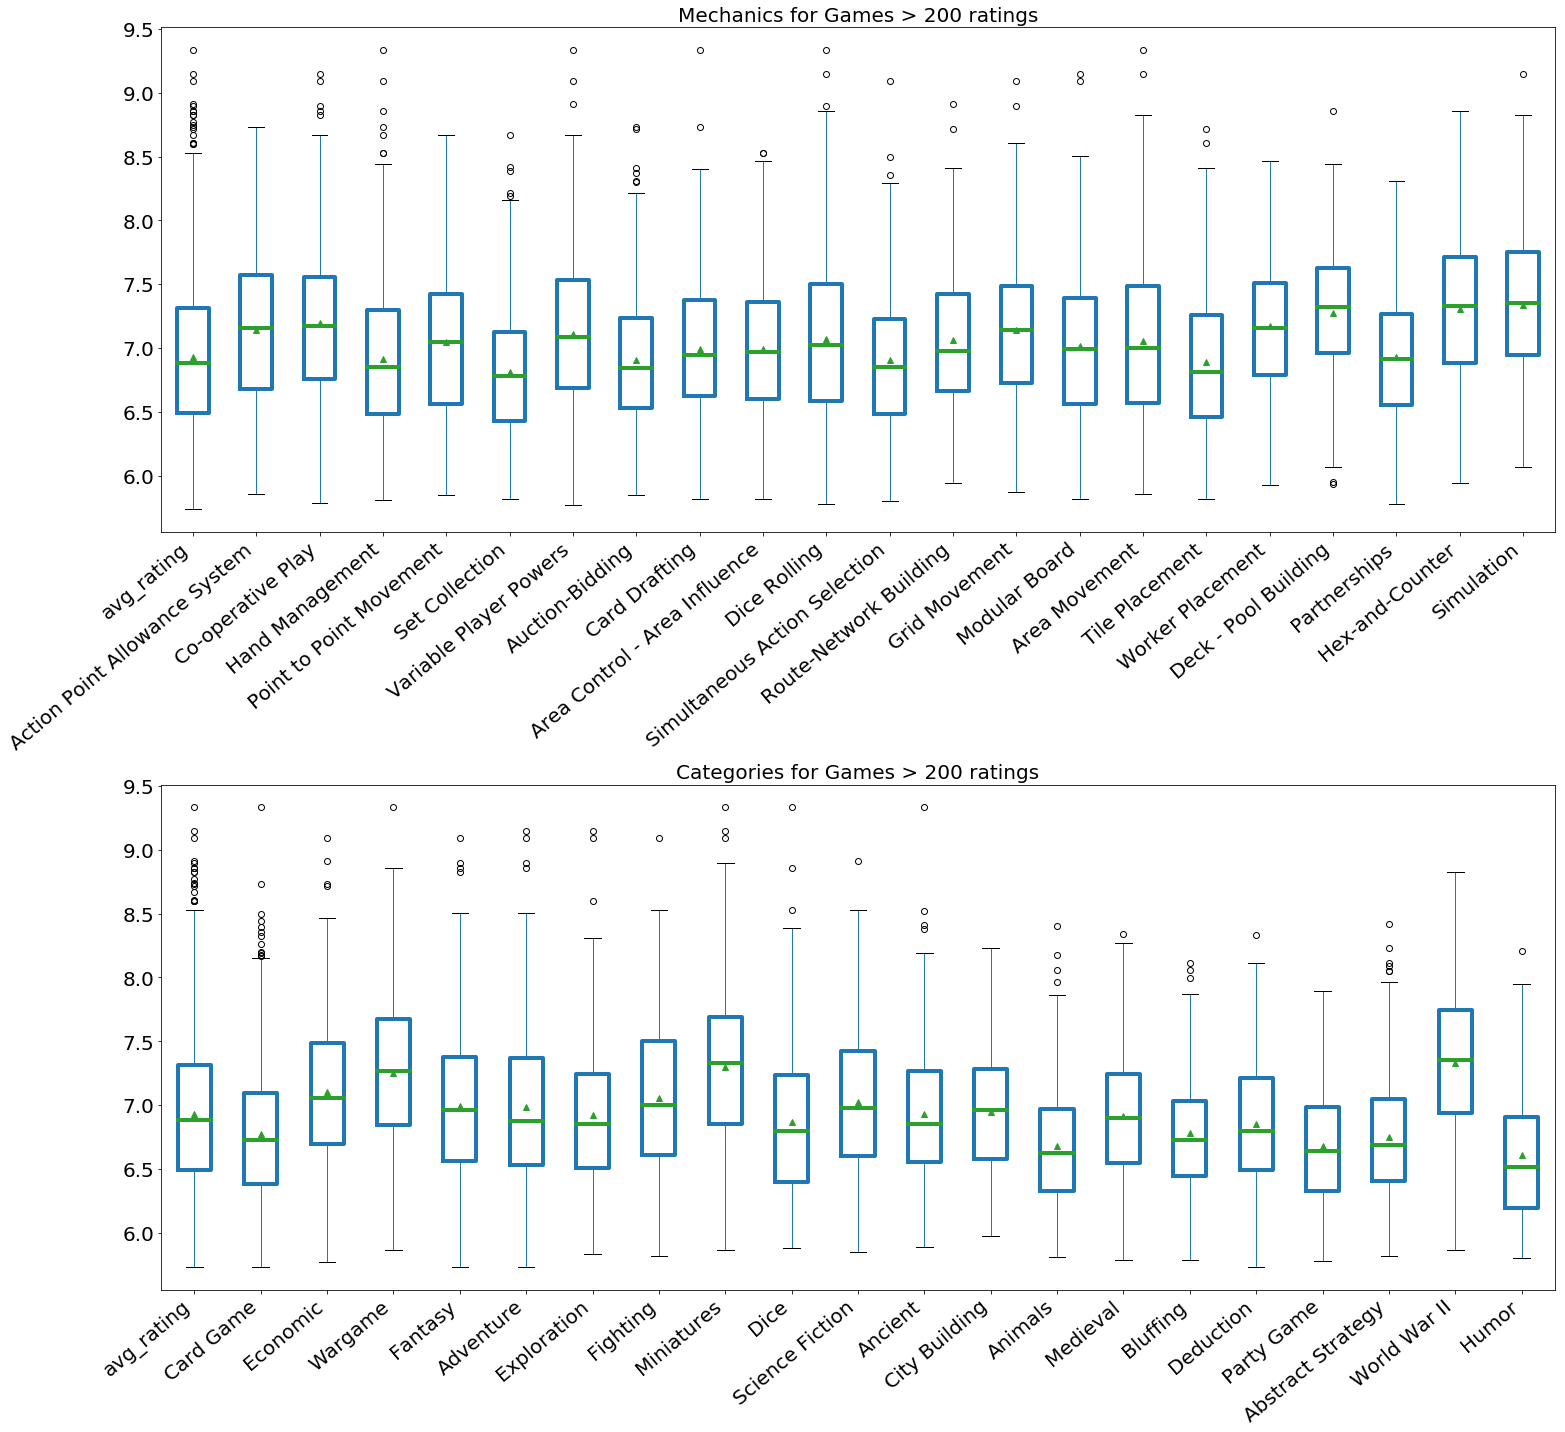

In [5]:
bgg_top_mechanics_data = bgg_mechanics_data[bgg_mechanics_data.columns[bgg_mechanics_data.count()>200]]

top_mechanics = bgg_top_mechanics_data.columns.values.tolist()[4:]
bgg_top_cat_data = bgg_cat_data[bgg_cat_data.columns[bgg_cat_data.count()>200]]
top_cat = bgg_top_cat_data.columns.values.tolist()[5:]

fig1, axes1 = plt.subplots(figsize=(22, 20), nrows=2)
boxprops = dict(linestyle='-', linewidth=4, color='k')
medianprops = dict(linestyle='-', linewidth=4, color='k')
bgg_top_mechanics_data.boxplot(top_mechanics, ax=axes1[0], boxprops=boxprops, medianprops=medianprops,
                               grid=False, showmeans=True)
axes1[0].set_xticklabels(top_mechanics, rotation=40, ha='right')
axes1[0].set_title('Mechanics for Games > 200 ratings')
bgg_top_cat_data.boxplot(top_cat, ax=axes1[1], boxprops=boxprops, medianprops=medianprops,
                         grid=False, showmeans=True)
axes1[1].set_xticklabels(top_cat, rotation=40, ha='right')
axes1[1].set_title('Categories for Games > 200 ratings')
for item in ([axes1[0].title, axes1[0].xaxis.label, axes1[0].yaxis.label,
              axes1[1].title, axes1[1].xaxis.label, axes1[1].yaxis.label] +
              axes1[0].get_xticklabels() + axes1[0].get_yticklabels() +
              axes1[1].get_xticklabels() + axes1[1].get_yticklabels()):
    item.set_fontsize(20)
plt.tight_layout()
plt.show()

It appears that the type of mechanics in the game did not seem to have a significant impact on the average user rating!

However, the categories the game falls under does have a significant impact!  You can clearly see that the average game with miniatures is rated higher than most other categories. 

Also of interest is the slight boost in ratings for wargames, and games themed around World War II.  Interestingly humor games have a much lower average rating. Wargaming has often been considered to be a distinct hobby from more main stream tabletop games, as players that enjoy wargames are a distinct subset of the larger board game community. 

<a name="minis"></a>
### Are Games Better with Miniatures? 

Let's look and see how games with and without miniatures are rated.

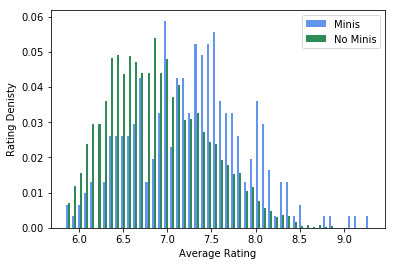

Ks_2sampResult(statistic=0.29681530968804881, pvalue=9.7558376957409278e-23)


In [6]:
fig2, ax2 = plt.subplots()
mini_heights, mini_bins = np.histogram(miniatures_comp['Miniatures'].dropna(axis=0), bins=50)
nomini_heights, nomini_bins = np.histogram(miniatures_comp['No Miniatures'].dropna(axis=0), bins=mini_bins)
mini_heights = mini_heights / miniatures_comp['Miniatures'].count()
nomini_heights = nomini_heights / miniatures_comp['No Miniatures'].count()
width = (mini_bins[1] - mini_bins[0])/3
ax2.bar(mini_bins[:-1], mini_heights, width=width, facecolor='cornflowerblue', label='Minis')
ax2.bar(nomini_bins[:-1]+width, nomini_heights, width=width, facecolor='seagreen', label='No Minis')
ax2.set_xlabel('Average Rating')
ax2.set_ylabel('Rating Denisty')
ax2.legend(loc='upper right')
plt.show()

# do Kolmogorov - Smirnov analysis of null hypothesis

print(ks_2samp(miniatures_comp['Miniatures'].dropna(axis=0),
               miniatures_comp['No Miniatures'].dropna(axis=0)))

Using the Kolmogorov-Smirov test, it looks like we cannot reject the null hypothesis. The distributions appear to be statistically different! An extremely small p-value of 9.7e-21%, a KS D statistic of 0.29 shows the max distance between the CDFS for the two distributions is 0.29 (in the average rating). Coupled with the extremely low p value, this result suggests that games with Miniatures are statistically rated higher!     